In [ ]:
!pip install transformers
!pip install datasets
!pip install matplotlib
!pip install scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [ ]:
# Install required packages
!pip install transformers datasets
!pip install scikit-learn
!pip install matplotlib

# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import ElectraTokenizer, ElectraModel
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [ ]:
import pandas as pd

# Load the data
true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')

# Add labels: 1 for True news, 0 for Fake news
true_df['label'] = 1
fake_df['label'] = 0

# Combine and shuffle the data
data = pd.concat([true_df, fake_df])
data = data.sample(frac=1).reset_index(drop=True)


In [ ]:
from transformers import ElectraTokenizer

tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

# Tokenize headlines or content
encodings = tokenizer(
    list(data['title']),  # or use 'text' column
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

input_ids = encodings['input_ids']
attention_masks = encodings['attention_mask']
labels = torch.tensor(data['label'].values)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

# Create TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create DataLoader
train_dataloader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=32)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [ ]:
import torch.nn as nn
from transformers import ElectraModel

class FakeNewsModel(nn.Module):
    def __init__(self):
        super(FakeNewsModel, self).__init__()
        self.electra = ElectraModel.from_pretrained('google/electra-small-discriminator')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.electra.config.hidden_size, 2)  # Binary classification (Fake or Real)

    def forward(self, input_ids, attention_mask):
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0]  # CLS token
        dropped = self.dropout(hidden_state)
        logits = self.classifier(dropped)
        return logits


In [ ]:
import torch

# Device setup (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model and move to device
model = FakeNewsModel().to(device)

# Define loss and optimizer
criterion = FocalLoss()  # If you’ve already defined the FocalLoss class
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)


In [ ]:
train_losses = []
train_accuracies = []

for epoch in range(5):  # Train for 5 epochs (adjust as needed)
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch in train_dataloader:
        # Move data to device (GPU or CPU)
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs  # Extract logits

        # Compute loss
        loss = criterion(logits, labels)
        loss.backward()

        # Update weights
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)

    # Calculate average loss and accuracy
    avg_loss = running_loss / len(train_dataloader)
    accuracy = correct_preds / total_preds

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1, Loss: 0.0273, Accuracy: 0.9610
Epoch 2, Loss: 0.0124, Accuracy: 0.9837


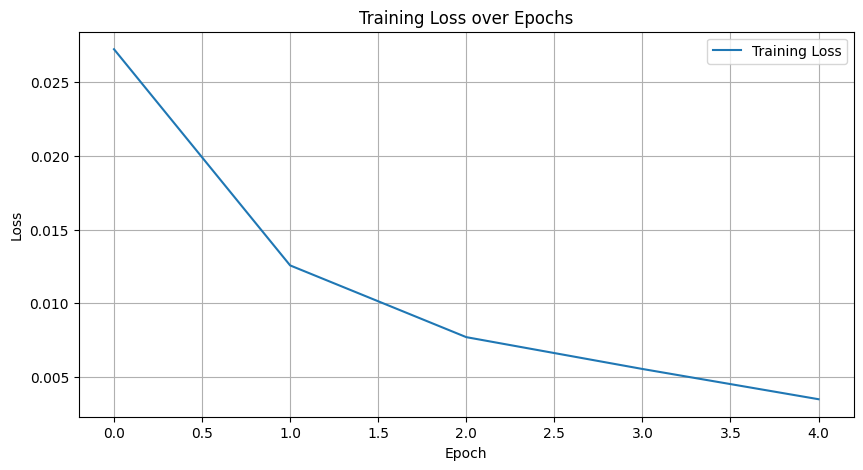

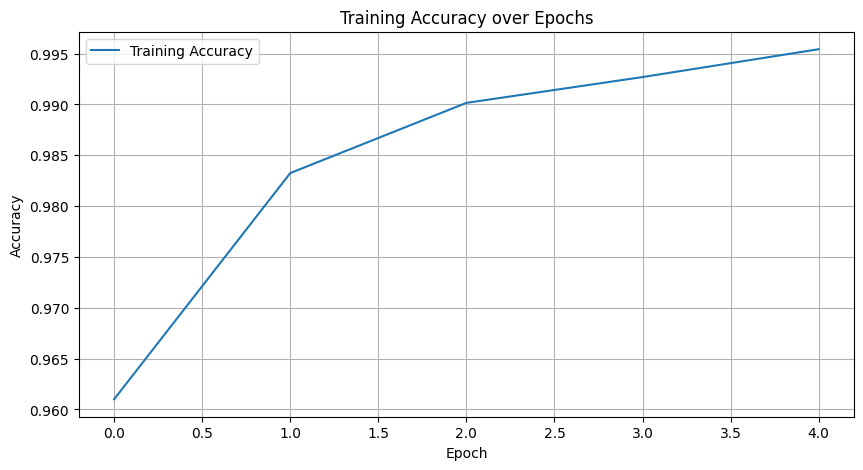

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Save
torch.save(model.state_dict(), "fake_news_model.pth")

# Load (if needed)
# model.load_state_dict(torch.load("fake_news_model.pth"))
# model.eval()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset (Fake.csv and True.csv)
fake_df = pd.read_csv('Fake.csv')  # Fake news data
true_df = pd.read_csv('True.csv')  # True news data

# Add labels: 0 for fake, 1 for true
fake_df['label'] = 0
true_df['label'] = 1

# Combine both dataframes
df = pd.concat([fake_df[['text', 'label']], true_df[['text', 'label']]])

# Split the data into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Check the split data
print(train_df.head(), test_df.head())


                                                    text  label
12854  ATHENS (Reuters) - Turkish President Tayyip Er...      1
12384  Ted Cruz would be fair, honest and most of all...      0
938    WASHINGTON (Reuters) - White House Chief of St...      1
1259   DUBAI (Reuters) - Saudi Arabia welcomed the ne...      1
3558   SIGONELLA, Italy (Reuters) - U.S. President Do...      1                                                     text  label
22216  21st Century Wire says Ben Stein, reputable pr...      0
4436   WASHINGTON (Reuters) - U.S. President Donald T...      1
1526   (Reuters) - Puerto Rico Governor Ricardo Rosse...      1
1377   On Monday, Donald Trump once again embarrassed...      0
8995   GLASGOW, Scotland (Reuters) - Most U.S. presid...      1


In [ ]:
from transformers import ElectraTokenizer
import torch

# Initialize the tokenizer
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

# Tokenize the test data
test_encodings = tokenizer(list(test_df['text']), truncation=True, padding=True, max_length=256, return_tensors='pt')

# Convert labels to tensors
test_labels = torch.tensor(test_df['label'].values)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Create a dataset for the test set
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

# Create DataLoader for batch processing
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
# Load the trained model
model = FakeNewsModel().to(device)  # Move model to the right device (GPU or CPU)
model.load_state_dict(torch.load("fake_news_model.pth"))
model.eval()  # Set the model to evaluation mode


FakeNewsModel(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=25

Test Accuracy: 0.6998
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.99      0.78      4733
           1       0.98      0.37      0.54      4247

    accuracy                           0.70      8980
   macro avg       0.81      0.68      0.66      8980
weighted avg       0.80      0.70      0.67      8980



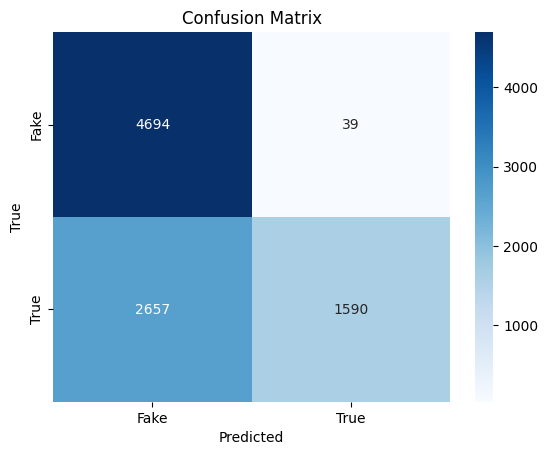

In [ ]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize variables to track predictions
all_labels = []
all_preds = []

# Disable gradient calculations to speed up inference
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        # Forward pass through the model
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs  # Extract logits from the output

        # Get predictions
        preds = torch.argmax(logits, dim=1)

        # Store the predictions and true labels
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Print the classification report
report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(report)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


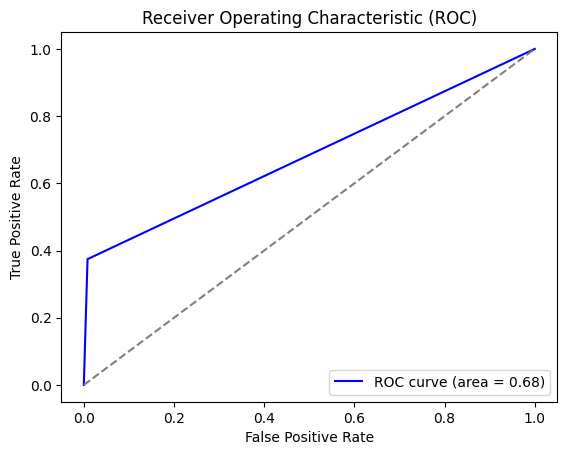

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.9761
Recall: 0.3744
F1 Score: 0.5412


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Assuming all_labels and all_preds are defined and contain the true labels and predicted probabilities
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# Calculate AUC
auc_score = roc_auc_score(all_labels, all_preds)

# Save evaluation metrics
with open('evaluation_metrics.csv', 'w', newline='') as csvfile:
    fieldnames = ['Metric', 'Value']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    writer.writerow({'Metric': 'Accuracy', 'Value': accuracy})
    writer.writerow({'Metric': 'Precision', 'Value': precision})
    writer.writerow({'Metric': 'Recall', 'Value': recall})
    writer.writerow({'Metric': 'F1 Score', 'Value': f1})
    writer.writerow({'Metric': 'AUC', 'Value': auc_score})


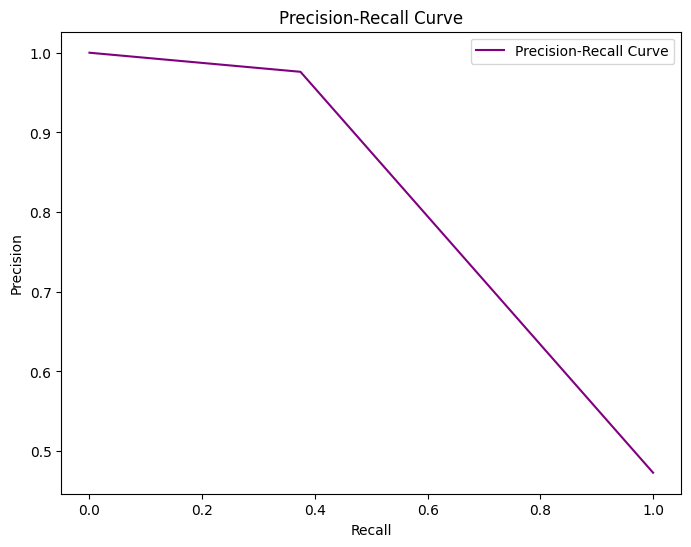

In [ ]:
from sklearn.metrics import precision_recall_curve

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(all_labels, all_preds)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


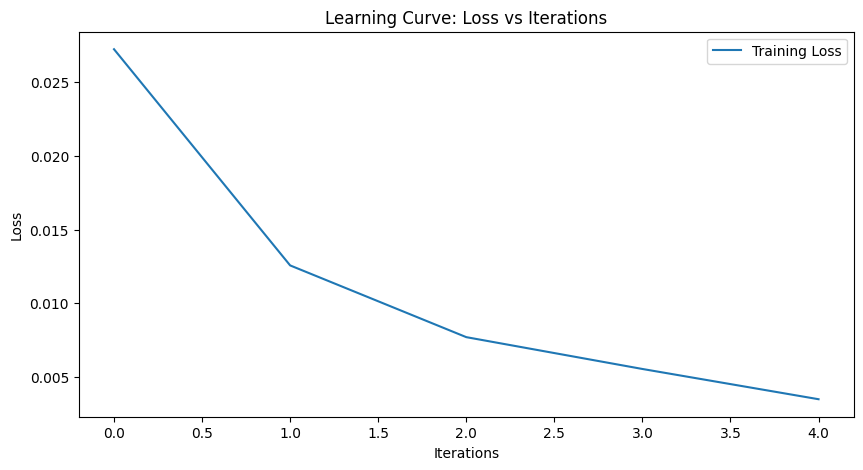

In [ ]:
# Plot learning curve (Loss vs Iterations)
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Learning Curve: Loss vs Iterations')
plt.legend()
plt.show()


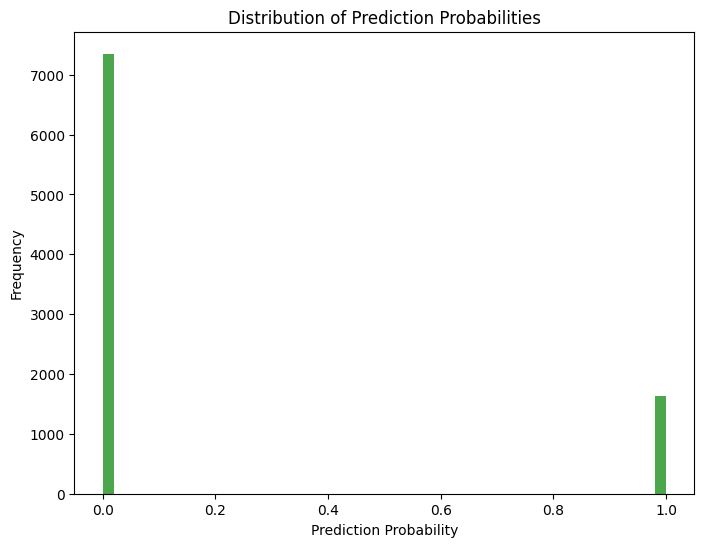

In [ ]:
# Plot distribution of predictions (probabilities)
plt.figure(figsize=(8, 6))
plt.hist(all_preds, bins=50, alpha=0.7, color='green')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Probabilities')
plt.show()


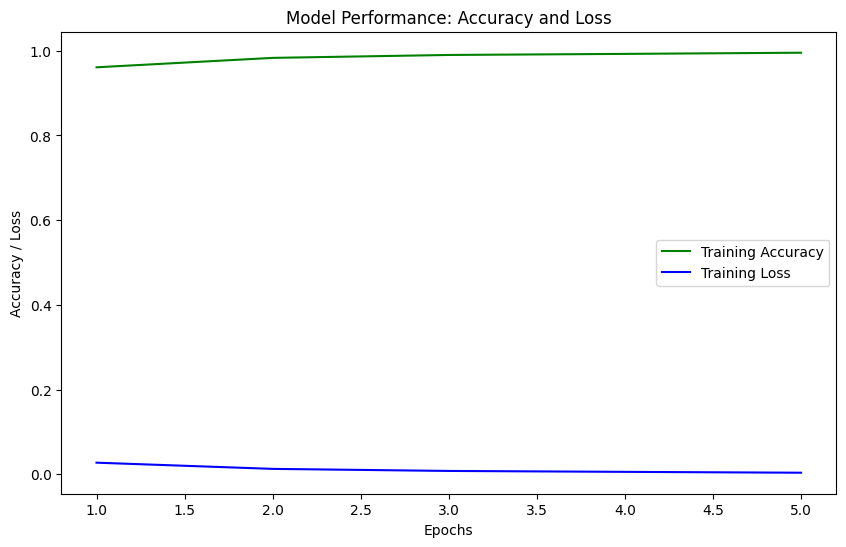

In [ ]:
# Plot Accuracy and Loss together
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='g')
plt.plot(epochs, train_losses, label='Training Loss', color='b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.title('Model Performance: Accuracy and Loss')
plt.legend()
plt.show()



In [ ]:
def predict_custom_text(text):
    model.eval()

    # Tokenize user input
    encoding = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=256
    )

    # Move to device (GPU or CPU)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        prediction = torch.argmax(outputs, dim=1).item()

    return "🟢 TRUE NEWS" if prediction == 1 else "🔴 FAKE NEWS"


In [ ]:
# Ask the user for input in Colab
user_input = input("Enter a news article or headline to verify: ")
result = predict_custom_text(user_input)
print("Prediction:", result)


Enter a news article or headline to verify: Post Pahalgam terror attack: India works to throttle Pak terror funding, get it back in watchdog FATF ‘grey list’
Prediction: 🔴 FAKE NEWS


In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.9 MB/s eta 0:00:00


In [ ]:
def predict_custom_text_gradio(text):
    model.eval()
    encoding = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=256
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        prediction = torch.argmax(outputs, dim=1).item()

    return "🟢 TRUE NEWS" if prediction == 1 else "🔴 FAKE NEWS"
